In [1]:
#Bailey Blum, Molly Giglia, Horacio Lopez & Ale Lopez

In [1]:
import json
import bigjson
import ijson
import pandas as pd
    

with open('yelp_dataset/review.json') as json_file:      
    data = json_file.readlines()
    # this line below may take at least 8-10 minutes of processing for 4-5 million rows. It converts all strings in list to actual json objects. 
    data = list(map(json.loads, data)) 

In [2]:
texts = [d['text'] for d in data]
stars = [d['stars'] for d in data]

In [3]:
from collections import Counter
 
def balance_classes(xs, ys):

    freqs = Counter(ys)

    # the least common class is the maximum number we want for all classes
    max_allowable = 25000
    #max_allowable = freqs.most_common()[-1][1]
    num_added = {clss: 0 for clss in freqs.keys()}
    new_ys = []
    new_xs = []
    for i, y in enumerate(ys):
        if num_added[y] < max_allowable:
            new_ys.append(y)
            new_xs.append(xs[i])
            num_added[y] += 1
    return new_xs, new_ys

In [4]:
print(Counter(stars))
balanced_x, balanced_y = balance_classes(texts, stars)
print(Counter(balanced_y))

Counter({5.0: 2933082, 4.0: 1468985, 1.0: 1002159, 3.0: 739280, 2.0: 542394})
Counter({1.0: 25000, 5.0: 25000, 4.0: 25000, 3.0: 25000, 2.0: 25000})


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
import datetime
 
# This vectorizer breaks text into single words and bi-grams
# and then calculates the TF-IDF representation
vectorizer = TfidfVectorizer(ngram_range=(1,2))
t1 = datetime.datetime.now()
 
# the 'fit' builds up the vocabulary from all the reviews
# while the 'transform' step turns each indivdual text into
# a matrix of numbers.
vectors = vectorizer.fit_transform(balanced_x)
print(datetime.datetime.now() - t1)

0:00:53.023010


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(vectors, balanced_y, test_size=0.20, random_state=42)

In [7]:
keep = set([1,2,4,5])
 
# calculate the indices for the examples we want to keep
keep_train_is = [i for i, y in enumerate(y_train) if y in keep]
keep_test_is = [i for i, y in enumerate(y_test) if y in keep]
 
# convert the train set
X_train2 = X_train[keep_train_is, :]
y_train2 = [y_train[i] for i in keep_train_is]
y_train2 = ["n" if (y == 1 or y == 2) else "p" for y in y_train2]
 
# convert the test set
X_test2 = X_test[keep_test_is, :]
y_test2 = [y_test[i] for i in keep_test_is]
y_test2 = ["n" if (y == 1 or y == 2) else "p" for y in y_test2]

In [8]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
 
# initialise the SVM classifier
classifier = LinearSVC()

In [9]:
classifier.fit(X_train2, y_train2)
preds = classifier.predict(X_test2)
print(classification_report(y_test2, preds))
print(confusion_matrix(y_test2, preds))
print(accuracy_score(y_test2, preds))

              precision    recall  f1-score   support

           n       0.95      0.95      0.95     10067
           p       0.95      0.95      0.95      9934

    accuracy                           0.95     20001
   macro avg       0.95      0.95      0.95     20001
weighted avg       0.95      0.95      0.95     20001

[[9569  498]
 [ 479 9455]]
0.9511524423778811


In [55]:
import matplotlib.pyplot as plt
import numpy as np

def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    
    # create plot
    plt.figure(figsize=(15,5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()

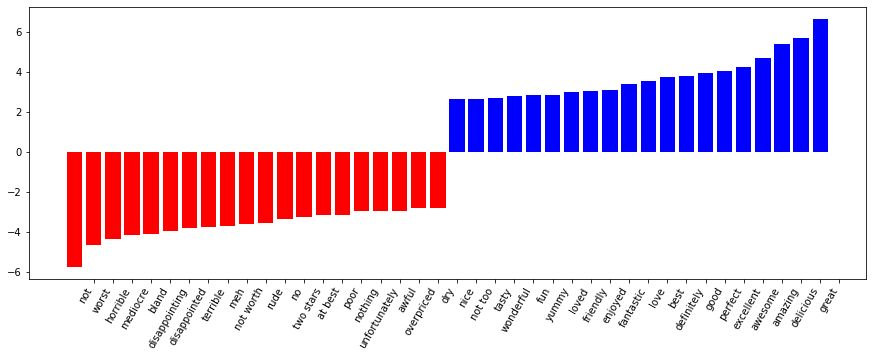

In [56]:
plot_coefficients(classifier, vectorizer.get_feature_names(), 20)